<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/saitama/saitama_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [294]:
import datetime
import json
import pathlib
import re
from collections import Counter
from urllib.parse import urljoin

In [295]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [296]:
from IPython.display import Image, display_png

In [297]:
def fetch_soup(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")

    return soup

In [298]:
def fetch_file(url, dir="."):

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    # 同一ファイル名の場合はダウンロードしない
    if not p.exists():

        r = requests.get(url)

        with p.open(mode="wb") as fw:
            fw.write(r.content)

    return p

In [299]:
def fetch_csv(url, text):

    soup = fetch_soup(url)
    href = soup.find_all("a", title=re.compile(text))[-1].get("href")

    csv_soup = fetch_soup(urljoin(url, href))
    csv_href = csv_soup.find("p", class_="muted ellipsis").find("a").get("href")

    p = fetch_file(csv_href, "download")

    return p

In [300]:
def str2date(s):

    lst = list(map(int, re.findall("\d+", s)))
    lst.insert(0, None)

    return lst[-3:]

In [301]:
def dumps_json(file_name, json_data, dir="."):

    p = pathlib.Path(dir, file_name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="w") as fw:
        json.dump(json_data, fw, ensure_ascii=False, indent=4)

## プログラム

In [302]:
# 検査陽性者の状況
MAIN_SUMMARY_URL = "http://www.pref.saitama.lg.jp/a0701/shingatacoronavirus.html"

In [303]:
soup = fetch_soup(MAIN_SUMMARY_URL)

In [304]:
# 更新日付取得
s = soup.select_one("#tmp_contents > h2").get_text()
m = re.search("([0-9]+)月([0-9]+)日", s)

month, day = map(int, m.groups())

In [305]:
dt_now = datetime.datetime.now()

In [306]:
dt_update = dt_now.replace(month=month, day=day, hour=21, minute=0, second=0, microsecond=0)

if dt_now < dt_update:
    dt_update = dt_update.replace(year=dt_now.year -1)

str_update = dt_update.strftime("%Y/%m/%d %H:%M")

In [307]:
data = {"lastUpdate": str_update}

In [308]:
tag = soup.select_one("#tmp_contents > div > div.outline > ul")

In [309]:
# 人数取得
text = tag.get_text(strip=True)

temp = {}

In [310]:
print(text)

県内の陽性確認者数：22,735人（1月22日新規公表分：358人）【内訳】入院：指定医療機関196人 一般医療機関699人 計895人（うち最重症者：7人 重症者：84人）宿泊療養：315人 自宅療養等：3,668人 退院・療養終了：退院6,130人 療養終了11,071人 計17,201人 死亡：298人(うち新型コロナウイルス感染症を死因とする死亡：245人)県内の疑い例検査数※検査数の詳細を見る（PDF：635KB）（1）自治体による検査（1月22日まで）：延べ52,158人（さいたま市・川越市・越谷市・川口市の実施分含む）【速報値】（2）民間検査機関等による検査（1月22日まで）：延べ361,154人【速報値】【留意事項】※1 検査実施人数は、同日までに実施した自治体による検査の累計と、同日までに報告のあった民間検査機関等による検査の累計の合計です。陰性確認のための検査数は含まれておりません。民間検査機関等による検査数は速報値のため、後日報告された分は報告日の検査数に計上されます。(特に休日の場合、検査実施人数の前日比は自治体による検査分のみが計上されるため、検査の実件数より大幅に少なく表記されます。)なお、右欄の陽性者数の前日比は休日の場合も含め、自治体による検査と民間医療機関等による検査で当日判明した陽性者数が計上、表記されます。※2 「自宅療養等」は、入院または宿泊療養調整中の方を含みます。※3 「新規公表分」は、調整を経て翌日に「入院中」「宿泊療養」「自宅療養等」に反映されます。※4 実際の退院日、療養終了日の翌日以降に報告された場合、報告日の件数に計上されます。※5 6月19日以降、新型コロナウイルス感染症の陽性者であって入院中や療養中に亡くなった方を「死亡」と表記し、うち新型コロナウイルス感染症を死因とする死亡者数を（　）内に内数として掲げています。なお、死亡には東京都が公表した1人を含みます。


In [311]:
for i in re.finditer(
    r"(陽性確認者数|新規公表分|指定医療機関|一般医療機関|最重症者|重症者|宿泊療養|自宅療養等|新型コロナウイルス感染症を死因とする死亡|死亡|新規公表分|退院・療養終了)：?([0-9,]+)人?",
    text,
):

    temp[i.group(1)] = int(i.group(2).replace(",", ""))

In [312]:
for i in re.finditer(r"(自治体による検査|民間検査機関等による検査)（\d{1,2}月\d{1,2}日まで）：延べ([0-9,]+)人", text):
    temp[i.group(1)] = int(i.group(2).replace(",", ""))

In [313]:
m = re.search("(入院)：(指定医療機関)([0-9,]+)人\s*(一般医療機関)([0-9,]+)人\s*(計)([0-9,]+)人", text)
if m:
    temp[f"{m.group(1)}_{m.group(2)}"] = int(m.group(3).replace(",", ""))
    temp[f"{m.group(1)}_{m.group(4)}"] = int(m.group(5).replace(",", ""))
    temp[f"{m.group(1)}_{m.group(6)}"] = int(m.group(7).replace(",", ""))

In [314]:
m = re.search("(退院・療養終了)：(退院)([0-9,]+)人\s*(療養終了)([0-9,]+)人\s*(計)([0-9,]+)人?", text)
if m:
    temp[f"{m.group(1)}_{m.group(2)}"] = int(m.group(3).replace(",", ""))
    temp[f"{m.group(1)}_{m.group(4)}"] = int(m.group(5).replace(",", ""))
    temp[f"{m.group(1)}_{m.group(6)}"] = int(m.group(7).replace(",", ""))

In [315]:
img_url = urljoin(MAIN_SUMMARY_URL, soup.select_one("div#tmp_contents > div.outline_type1 > div > p > img").get("src"))
p_img = fetch_file(img_url)

In [316]:
temp

{'一般医療機関': 699,
 '入院_一般医療機関': 699,
 '入院_指定医療機関': 196,
 '入院_計': 895,
 '宿泊療養': 315,
 '指定医療機関': 196,
 '新型コロナウイルス感染症を死因とする死亡': 245,
 '新規公表分': 358,
 '最重症者': 7,
 '死亡': 298,
 '民間検査機関等による検査': 361154,
 '自宅療養等': 3668,
 '自治体による検査': 52158,
 '退院・療養終了_療養終了': 11071,
 '退院・療養終了_計': 17201,
 '退院・療養終了_退院': 6130,
 '重症者': 84,
 '陽性確認者数': 22735}

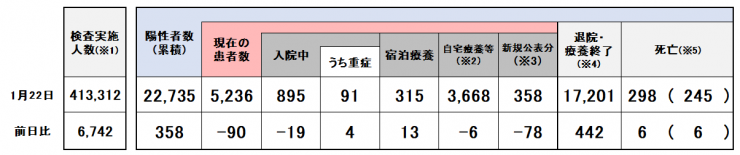

In [317]:
display_png(Image(str(p_img)))

In [318]:
temp["現在の患者数"] = temp["陽性確認者数"] - temp["退院・療養終了_計"] - temp["死亡"]

In [319]:
print("検査実施人数:", temp["自治体による検査"] + temp["民間検査機関等による検査"])
print("陽性患者数 (累計):", temp["陽性確認者数"])
print("現在の患者数:", temp["現在の患者数"])
print("入院中:", temp["入院_計"])
print("重症:", temp["重症者"] + temp["最重症者"])
print("宿泊療養:", temp["宿泊療養"])
print("自宅療養:", temp["自宅療養等"])
print("新規公表分:", temp["新規公表分"])
print("退院・療養終了:", temp["退院・療養終了_計"])
print("死亡:", temp["死亡"])

検査実施人数: 413312
陽性患者数 (累計): 22735
現在の患者数: 5236
入院中: 895
重症: 91
宿泊療養: 315
自宅療養: 3668
新規公表分: 358
退院・療養終了: 17201
死亡: 298


In [320]:
# 入院中
print(temp["入院_計"])
print(temp["現在の患者数"] - temp["宿泊療養"] - temp["自宅療養等"] - temp["新規公表分"])
print(temp["指定医療機関"] + temp["一般医療機関"])

895
895
895


In [321]:
hospital = [temp.get("入院_計"), temp["現在の患者数"] - temp["宿泊療養"] - temp["自宅療養等"] - temp["新規公表分"], temp["指定医療機関"] + temp["一般医療機関"]]
h = [k for k, v in Counter(hospital).items() if v > 1]
temp["入院中"] = h[0] if h else 0

In [322]:
data["main_summary"] = {
    "attr": "検査実施人数",
    "value": temp["自治体による検査"],
    "children": [
        {
            "attr": "陽性患者数",
            "value": temp["陽性確認者数"],
            "children": [
                {
                    "attr": "入院中",
                    "value": temp["入院中"],
                    "children": [
                        {
                            "attr": "軽症・中等症",
                            "value": temp["陽性確認者数"]
                            - temp["退院・療養終了_計"]
                            - temp["死亡"]
                            - temp["最重症者"]
                            - temp["重症者"],
                        },
                        {"attr": "重症", "value": temp["最重症者"] + temp["重症者"]},
                    ],
                },
                {"attr": "退院", "value": temp["退院・療養終了_計"]},
                {"attr": "死亡", "value": temp["死亡"]},
            ],
        }
    ],
}

In [323]:
# main_summary.json
main_summary = {
    "attr": "検査実施人数",
    "value": temp["自治体による検査"],
    "children": [
        {
            "attr": "陽性患者数",
            "value": temp["陽性確認者数"],
            "children": [
                {
                    "attr": "入院中",
                    "value": temp["入院中"],
                    "children": [
                        {"attr": "重症", "value": temp["最重症者"] + temp["重症者"]},
                    ],
                },
                {"attr": "宿泊療養", "value": temp["宿泊療養"]},
                {"attr": "自宅療養", "value": temp["自宅療養等"]},
                {"attr": "新規公表分", "value": temp["新規公表分"]},
                {"attr": "死亡", "value": temp["死亡"]},
                {"attr": "退院・療養終了", "value": temp["退院・療養終了_計"]},
            ],
        }
    ],
    "lastUpdate": str_update,
}

In [324]:
dumps_json("main_summary.json", main_summary, "data")

# 検査

## 前処理

In [325]:
# 検査数
KENSA_URL = "https://opendata.pref.saitama.lg.jp/data/dataset/covid19-kensa"
KENSA_TITLE = "^埼玉県が実施した新型コロナウイルス疑い例検査数"

In [326]:
# 検査
kensa_path = fetch_csv(KENSA_URL, KENSA_TITLE)

In [327]:
df_kensa = pd.read_csv(kensa_path, encoding="cp932")

In [328]:
df_date = (
    df_kensa["検査日"]
    .astype("str")
    .str.normalize("NFKC")
    .apply(str2date)
    .apply(pd.Series)
    .rename(columns={0: "year", 1: "month", 2: "day"})
)

In [329]:
df_date["year"] = df_date["year"].replace({20: 2020, 21: 2021}).fillna(method="ffill")
df_kensa["検査日"] = pd.to_datetime(df_date, errors="coerce")

In [330]:
df_kensa = df_kensa.set_index("検査日")
df_kensa.rename(columns={"検査数（延べ人数）": "小計"}, inplace=True)
df_kensa["日付"] = df_kensa.index.strftime("%Y-%m-%dT08:00:00.000Z")

## inspections_summary

In [331]:
df_insp_sum = df_kensa.loc[:, ["日付", "小計"]]

In [332]:
data["inspections_summary"] = {
    "data": df_insp_sum.to_dict(orient="records"),
    "date": str_update,
}

# 陽性患者数

## 前処理

In [333]:
# 陽性患者数
JOKYO_URL = "https://opendata.pref.saitama.lg.jp/data/dataset/covid19-jokyo"
JOKYO_TITLE = "^埼玉県内の新型コロナウイルス感染症の発生状況"

In [334]:
# 状況
jokyo_path = fetch_csv(JOKYO_URL, JOKYO_TITLE)

In [335]:
df_kanja = pd.read_csv(jokyo_path, encoding="cp932")

In [336]:
df_temp = (
    df_kanja["判明日"]
    .astype("str")
    .str.normalize("NFKC")
    .apply(str2date)
    .apply(pd.Series)
    .rename(columns={0: "year", 1: "month", 2: "day"})
)

In [337]:
df_temp["year"] = df_temp["year"].replace({20: 2020, 21: 2021}).fillna(method="ffill")
df_kanja["date"] = pd.to_datetime(df_temp, errors="coerce")

## チェック

In [338]:
# 2020年より前を抽出
df_kanja[df_kanja["date"] < datetime.datetime(2020, 1, 1)]

,NO.,判明日,年代,性別,居住地,date


In [339]:
# 未来の日付を抽出
df_kanja[df_kanja["date"] > dt_now]

,NO.,判明日,年代,性別,居住地,date


In [340]:
# 日付が空で調査中、発生届取り下げ、東京都発表、重複でないものを抽出
df_kanja[(df_kanja["date"].isna()) & ~((df_kanja["判明日"].isin(["調査中", "発生届取り下げ", "東京都発表"]) | df_kanja["判明日"].str.contains("重複", na=False)))]

,NO.,判明日,年代,性別,居住地,date
2281,2282,NaN,50代,男性,NaN,NaT
2436,2437,NaN,50代,男性,県外,NaT
4639,4640,NaN,NaN,NaN,入間市,NaT
4640,4641,NaN,NaN,NaN,入間市,NaT
4667,4668,NaN,NaN,女性,NaN,NaT
6682,6683,NaN,60代,男性,NaN,NaT
9234,9235,NaN,NaN,女性,NaN,NaT
9235,9236,NaN,NaN,女性,NaN,NaT
9650,9651,NaN,70代,男性,草加市,NaT
9651,9652,NaN,70代,女性,草加市,NaT


## patients_summary

In [341]:
ser_patients_sum = df_kanja["date"].value_counts().sort_index()

In [342]:
dt_range = pd.date_range(ser_patients_sum.index[0], df_kensa.index[-1])
ser_patients_sum = ser_patients_sum.reindex(index=dt_range, fill_value=0)

In [343]:
df_patients_sum = pd.DataFrame({"小計": ser_patients_sum})

In [344]:
df_patients_sum["日付"] = df_patients_sum.index.strftime("%Y-%m-%dT08:00:00.000Z")

In [345]:
data["patients_summary"] = {
    "data": df_patients_sum.to_dict(orient="records"),
    "date": str_update,
}

## patients

In [346]:
df_kanja.rename(columns={"NO.": "No"}, inplace=True)

In [347]:
df_kanja["判明日"] = df_kanja["判明日"].fillna("調査中")

In [348]:
df_kanja["リリース日"] = df_kanja["date"].dt.strftime("%Y-%m-%dT08:00:00.000Z")
df_kanja["リリース日"] = df_kanja["リリース日"].mask(df_kanja["判明日"] == "調査中", "調査中")

In [349]:
df_kanja["date"] = df_kanja["date"].dt.strftime("%Y-%m-%d")
df_kanja["date"] = df_kanja["date"].mask(df_kanja["判明日"] == "調査中", "調査中").fillna("調査中")

In [350]:
df_kanja["退院"] = ""

In [351]:
df_patients = df_kanja.loc[:, ["No", "リリース日", "年代", "性別", "居住地", "退院", "date"]].copy()
df_patients.dropna(subset=["リリース日"], inplace=True)
df_patients.fillna("", inplace=True)

In [352]:
data["patients"] = {
    "data": df_patients.to_dict(orient="records"),
    "date": str_update,
}

In [353]:
dumps_json("data.json", data, "data")